# Noise2Self for Neural Nets

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks.

For didactic purposes, we use a simple dataset (Gaussian noise on MNIST), a simple model (a small UNet), and a short training (100 iterations on a CPU). This notebook runs on a MacBook Pro in under one minute.

In [1]:
%gui qt

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

In [4]:
import numpy as np

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [5]:
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [6]:
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

We will try to learn to predict the clean image on the right from the noisy image on the left.

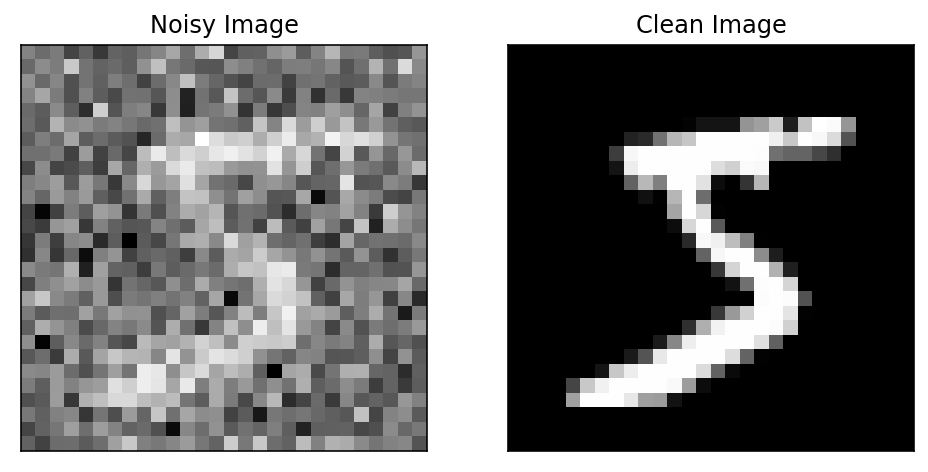

In [7]:
noisy, clean = noisy_mnist_train[0]
plot_tensors([noisy[0], clean[0]], ['Noisy Image', 'Clean Image'])

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [8]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

In [9]:
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)

A mask; the data; the input to the neural net, which doesn't depend on the values of $x$ inside the mask; and the difference between the neural net input and $x$.

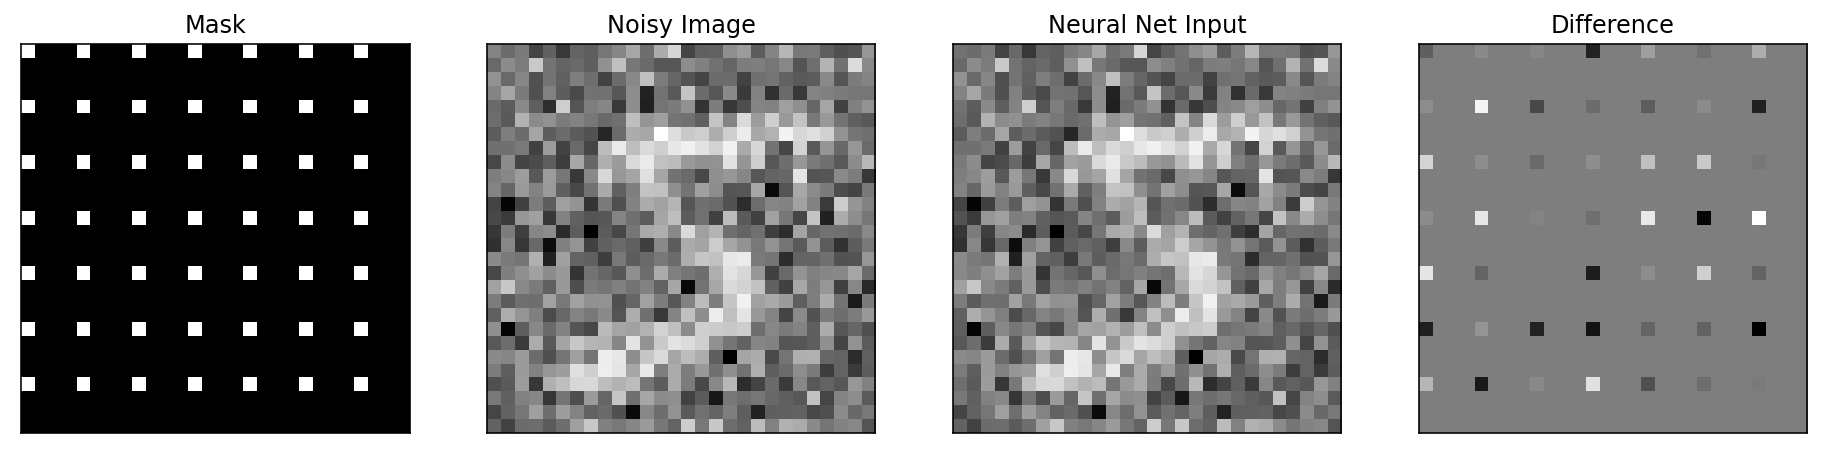

In [10]:
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [11]:
from models.babyunet import BabyUnet
model = BabyUnet()

# Training

In [12]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Visualization

We lazily convert the torch tensors to NumPy arrays and concatenate them into dask arrays containing all the data. We do this for the training (noisy) data, the ground truth, and the model output.

There's a bit of reshaping because torch data comes with extra dimensions that we want to squeeze out, to only get a `(nsamples, size_y, size_x)` volume.

In [13]:
import dask
import dask.array as da

noisy_test_dask = da.stack(
    [
        da.from_delayed(
            dask.delayed(lambda i: noisy_mnist_test[i][0].detach().numpy())(i),
            shape=(1, 28, 28),
            dtype=np.float32
        ).reshape((28, 28))
        for i in range(len(noisy_mnist_test))
    ]
)

clean_test_dask = da.stack(
    [
        da.from_delayed(
            dask.delayed(lambda i: noisy_mnist_test[i][1].detach().numpy())(i),
            shape=(1, 28, 28),
            dtype=np.float32
        ).reshape((28, 28))
        for i in range(len(noisy_mnist_test))
    ]
)

In [14]:
import torch

def test_numpy_to_result_numpy(i):
    """Convert test NumPy array to model output and back to NumPy."""
    out = model(
        torch.Tensor(np.array(noisy_test_dask[i:i+1, np.newaxis]))
    ).detach().numpy().squeeze()
    return out

# build the results dask array
model_output_dask = da.stack(
    [
        da.from_delayed(
            dask.delayed(test_numpy_to_result_numpy)(i),
            shape=(28, 28),
            dtype=np.float32
        )
        for i in range(len(noisy_mnist_test))
    ]
)

Build the napari viewer for all three volumes simultaneously:

In [15]:
import napari


viewer = napari.Viewer()
_ = viewer.add_image(clean_test_dask)  # returns layer, we don't care
_ = viewer.add_image(noisy_test_dask)
model_layer = viewer.add_image(
    model_output_dask,
    contrast_limits=(
        np.min(noisy_test_dask[0:10]).compute(),
        np.max(noisy_test_dask[0:10]).compute()
    )
)  # this layer though, we're gonna play with
viewer.grid_view()

We turn off dask caching because we want the model to re-evaluate each time we view a model output.

In [16]:
from napari.utils import resize_dask_cache
resize_dask_cache(0)

Finally, build a loss plot and refresh the viewer on each batch:

In [17]:
from napari.qt import thread_worker
from matplotlib.backends.backend_qt5agg import FigureCanvas
from matplotlib.figure import Figure

NUM_ITER = 100


# build the plot, but don't display it yet
# — we'll add it to the napari viewer later
with plt.style.context('dark_background'):
    loss_canvas = FigureCanvas(Figure(figsize=(5, 3)))
    loss_axes = loss_canvas.figure.subplots()
    lines = loss_axes.plot([], [])  # make empty plot
    loss_axes.set_xlim(0, NUM_ITER)
    loss_axes.set_xlabel('batch number')
    loss_axes.set_ylabel('loss')
    loss_canvas.figure.tight_layout()
    loss_line = lines[0]


# when getting a new loss, update the plot
def update_plot(loss):
    x, y = loss_line.get_data()
    new_y = np.append(y, loss)
    new_x = np.arange(len(new_y))
    loss_line.set_data(new_x, new_y)
    loss_axes.set_ylim(
        np.min(new_y) * (-0.05), np.max(new_y) * (1.05)
    )
    loss_canvas.draw()


# and update the model output layer
def update_viewer(loss):
    model_layer.refresh()
    viewer.help = f'loss: {loss}'


# define a function to train the model in a new thread,
# connecting the yielded loss values to our update functions
@thread_worker(connect={'yielded': [update_viewer, update_plot]})
def train(model, data_loader, n_iter):

    for i, batch in zip(range(n_iter), data_loader):
        noisy_images, clean_images = batch

        net_input, mask = masker.mask(noisy_images, i)
        net_output = model(net_input)

        loss = loss_function(net_output*mask, noisy_images*mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        yield round(loss.item(), 4)


# finally, add the plot to the viewer, and start training!
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

viewer.window.add_dock_widget(loss_canvas)
worker = train(model, data_loader, NUM_ITER)

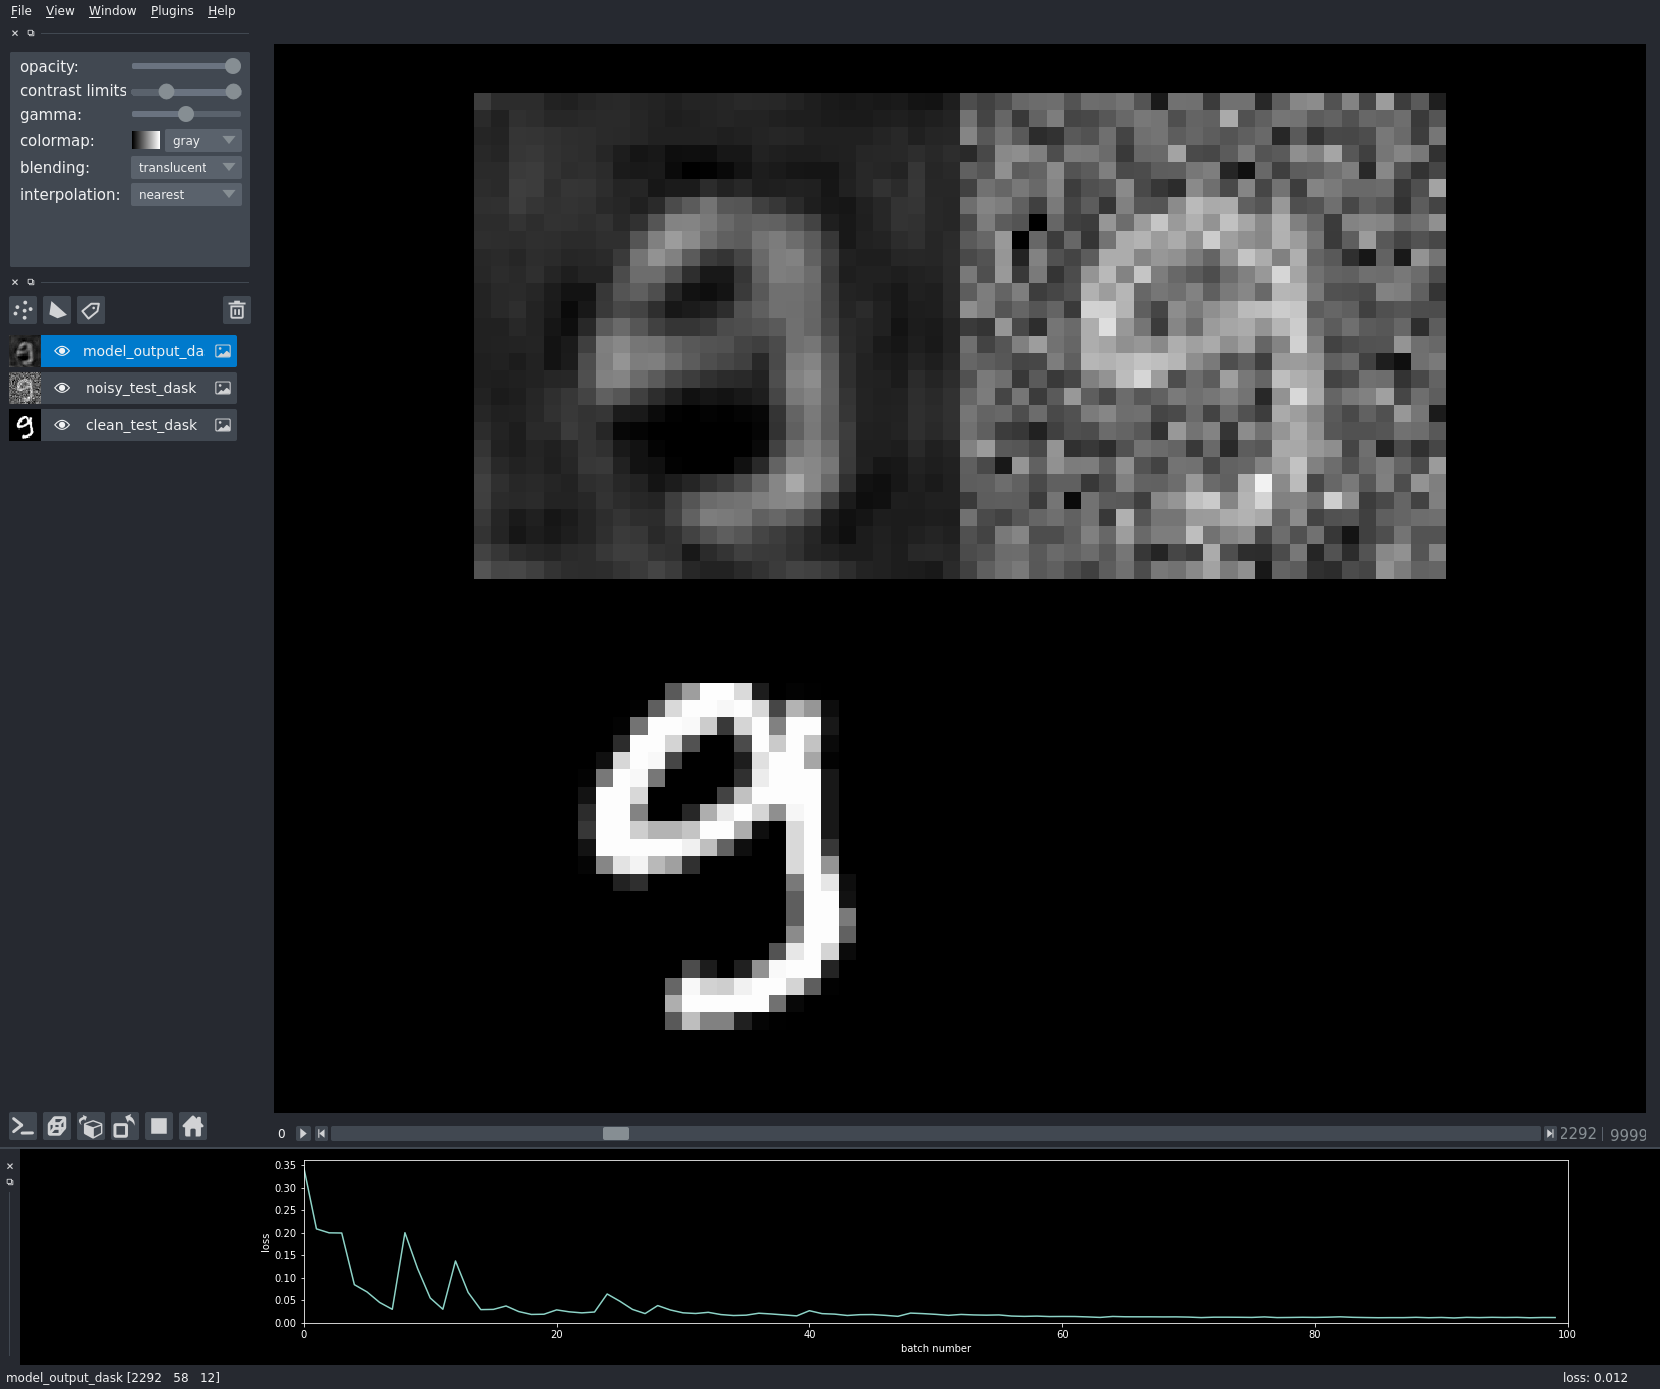

In [18]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

# J-invariant reconstruction

With our trained model, we have a choice. We may do a full $J$-invariant reconstruction, or we may just run the noisy data through the network unaltered.

In [ ]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

In [ ]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

In [ ]:
type(simple_output)

In [ ]:
np.asarray(simple_output)

`torch.Tensor.__array__` is hampered because the developers want to prevent accidentally dropping gradient. See:

https://discuss.pytorch.org/t/should-it-really-be-necessary-to-do-var-detach-cpu-numpy/35489

For demo purposes, we increase the magic of torch Tensors.

In [ ]:
import torch

In [ ]:
def array(self, dtype=None):
    if dtype is None:
        return self.detach().numpy()
    else:
        return self.detach().numpy().astype(dtype, copy=False)

torch.Tensor.__array__ = array

In [ ]:
np.array(simple_output)

In [ ]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    noisy, name='noisy',
    contrast_limits=[-1.5, 2.5],
)
viewer.add_image(
    simple_output, name='simple output',
    contrast_limits=[-0.5, 1.5],
)
viewer.add_image(
    invariant_output, name='j-invariant output',
    contrast_limits=[-0.5, 1.5],
)

While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation. 

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.